# Create Zarr of 9 years of hourly CSSP China data [1851-1859]

In [1]:
import iris
import os
import sys
import logging
import xarray as xr
import numpy as np

import crd_utils as crd
import umdates_utils as um

from datetime import datetime, timedelta

## Create a list of all the files we want to process

In [2]:
# hourly data filenames
filepath = '/data/cssp-china/mini-dataset-24-01-19/20CR/hourly'
files = sorted(os.listdir(filepath))
print(len(files))

5850


In [3]:
# generate all possible filenames for the time period
runid = 'apepd'
startd = datetime(1851, 1, 1)   # 00Z on Jan 01 1851
endd = datetime(1860, 1, 1)     # 00Z on Jan 01 1860
freq = 'pj'

decade_filenames = um.UMFileList(runid, startd, endd, freq)
print(len(decade_filenames))

3288


In [4]:
# find the overlap of actual filenames with all possible filenames in that decade
filenames = list(set(files).intersection(set(decade_filenames)))
filenames.sort()
print(len(filenames))

329


In [5]:
filepaths = [os.path.join(filepath, filename) for filename in filenames]
print(len(filepaths))

329


## Set all the Cube, Dataset and Zarr variables we need to process the cubes

In [6]:
%%time
cubelist = iris.load(filepaths[0:1])
cubelist[0]

CPU times: user 1.19 s, sys: 79.6 ms, total: 1.27 s
Wall time: 2.13 s


<iris 'Cube' of surface_air_pressure / (Pa) (time: 97; grid_latitude: 219; grid_longitude: 286)>

In [7]:
print(cubelist)

0: surface_air_pressure / (Pa)         (time: 97; grid_latitude: 219; grid_longitude: 286)
1: x_wind / (m s-1)                    (time: 97; grid_latitude: 218; grid_longitude: 286)
2: y_wind / (m s-1)                    (time: 97; grid_latitude: 218; grid_longitude: 286)


In [8]:
CUBENAMES = [cube.name() for cube in cubelist]
UNIQUE_COORDS = crd.unique_coords_list(cubelist)
COORD_NAME_MAPPING = crd.get_new_coord_names(UNIQUE_COORDS)

In [9]:
print([coord.name() for coord in UNIQUE_COORDS])

['time', 'grid_latitude', 'grid_longitude', 'forecast_reference_time', 'forecast_period', 'grid_latitude', 'grid_longitude', 'height']


In [10]:
COORD_NAME_MAPPING[1]

('grid_latitude_1', 'grid_longitude_1')

In [11]:
ZARR = '/data/cssp-china/zarr_hourly_1851-1859'
CHUNKS = {'time': 200, 'grid_latitude': 219, 'grid_longitude': 286, 'grid_latitude_1': 218, 'grid_longitude_1': 286}

## Initialise logging

In [12]:
LOGFILE = '/data/cssp-china/zarr_append_hourly.log'
logging.basicConfig(filename=LOGFILE,
                    level=logging.DEBUG,
                    format='%(asctime)s %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S')

In [13]:
if not os.path.isfile(LOGFILE):
    os.mknod(LOGFILE)

if os.stat(LOGFILE).st_size == 0:
    logging.info('Initiate log')
    print(f'Log initiated at {LOGFILE}')

## Create a Zarr with 3 cubes, which definitely amounts to 577 time steps (~25 days)

In [22]:
%%time
cubelist0 = iris.load(filepaths[0:3])
cubelist0[1]

CPU times: user 6.92 s, sys: 376 ms, total: 7.3 s
Wall time: 8.42 s


<iris 'Cube' of x_wind / (m s-1) (time: 577; grid_latitude: 218; grid_longitude: 286)>

In [23]:
%%time
crd.rename_cubes(cubelist0, CUBENAMES, COORD_NAME_MAPPING, dryrun=False)

surface_air_pressure
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x forecast_period
x_wind
  x time
    grid_latitude_1
    grid_longitude_1
  x forecast_reference_time
  x height
  x forecast_period
y_wind
  x time
    grid_latitude_1
    grid_longitude_1
  x forecast_reference_time
  x height
  x forecast_period
CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 2.02 ms


In [24]:
%%time
dalist0 = crd.cubelist_to_dalist(cubelist0)
ds0 = xr.merge(dalist0)

CPU times: user 35.5 ms, sys: 3.96 ms, total: 39.5 ms
Wall time: 52.2 ms


In [25]:
ds0

<xarray.Dataset>
Dimensions:                  (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, time: 577)
Coordinates:
  * time                     (time) datetime64[ns] 1851-01-01 ... 1851-01-25
  * grid_latitude            (grid_latitude) float32 22.88 22.66 ... -25.08
  * grid_longitude           (grid_longitude) float32 323.48 323.7 ... 386.18002
    forecast_reference_time  datetime64[ns] 1849-12-01
    forecast_period          (time) timedelta64[ns] 396 days 00:00:00 ... 420 days 00:00:00
  * grid_latitude_1          (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude_1         (grid_longitude_1) float32 323.59003 ... 386.29004
    height                   float64 10.0
Data variables:
    surface_air_pressure     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    x_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(1, 218, 286), meta=np.ndarray>
    y_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(1, 218, 286), meta=np.ndarray>

In [26]:
%%time
logging.info(f'Creating {ZARR}')
crd.ds_to_zarr(ds0, ZARR, chunks=CHUNKS)

CPU times: user 4.49 s, sys: 1.27 s, total: 5.77 s
Wall time: 17.6 s


In [27]:
dsz0 = xr.open_zarr(ZARR)
dsz0

<xarray.Dataset>
Dimensions:                  (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, time: 577)
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(577,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...
  * grid_latitude            (grid_latitude) float32 22.88 22.66 ... -25.08
  * grid_latitude_1          (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude           (grid_longitude) float32 323.48 323.7 ... 386.18002
  * grid_longitude_1         (grid_longitude_1) float32 323.59003 ... 386.29004
    height                   float64 ...
  * time                     (time) datetime64[ns] 1851-01-01 ... 1851-01-25
Data variables:
    surface_air_pressure     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    x_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>
    y_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>

In [28]:
# Size of Dataset in GB
dsz0.nbytes / 1e9

0.432370924

In [31]:
logging.info(f'  Successfull creation of {ZARR}')
logging.info(f'  Processed filenames 0:{filenames[0]} - 3:{filenames[3]}')
logging.info(f'  Chunking {CHUNKS}')

## Now loop through the remaining cubes and append to the Zarr we created

In [14]:
def logprint(message):
    logging.info(message)
    print(message)

In [15]:
%%time
# Loop through in bunches of 2 cubes, so as to not use to much memory at one time
start = 207
step = 2
stop = len(filepaths)
# stop = start+(2*step)

logprint(f'Appending data to {ZARR}')

for i in range(start, stop, step):
    fnames = filenames[i:i+step]
    logprint(f'  Processing filenames {i}:{fnames[0]} - {min([i+step, stop])}:{fnames[-1]}')
    try:
        cubelist = iris.load(filepaths[i:i+step])
        logprint(f'  | Loaded files successfully')
        
        crd.rename_cubes(cubelist, CUBENAMES, COORD_NAME_MAPPING, dryrun=False, verbose=False)
        logprint(f'  | Renamed files successfully')
        
        dalist = crd.cubelist_to_dalist(cubelist)
        ds = xr.merge(dalist)
        logprint(f'  | Created dataset successfully')
        
        crd.ds_to_zarr(ds, ZARR, chunks=CHUNKS)
        logprint(f'  | Appended to Zarr {ZARR} successfully')
        
    except Exception as e:
        logprint(f'  X ERROR: {e}')
        raise e

logprint(f'  Appending data complete')

Appending data to /data/cssp-china/zarr_hourly_1851-1859
  Processing filenames 207:apepda.pj56950.pp - 209:apepda.pj569f0.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 209:apepda.pj569p0.pp - 211:apepda.pj56a50.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 211:apepda.pj56af0.pp - 213:apepda.pj56ap0.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 213:apepda.pj56b40.pp - 215:apepda.pj56be0.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully

/root/my-conda-envs/pangolin/lib/python3.6/site-packages/iris/fileformats/pp.py:1804: UserWarning: Unable to interpret field 147. Unsupported header release number: 277631283. Skipping the remainder of the file.
  warnings.warn(msg)


  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 221:apepda.pj571n0.pp - 223:apepda.pj57220.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 223:apepda.pj572c0.pp - 225:apepda.pj572m0.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 225:apepda.pj57340.pp - 227:apepda.pj573e0.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
  | Appended to Zarr /data/cssp-china/zarr_hourly_1851-1859 successfully
  Processing filenames 227:apepda.pj573o0.pp - 229:apepda.pj57430.pp
  | Loaded files successfully
  | Renamed files successf

In [16]:
dsz1 = xr.open_zarr(ZARR)
dsz1

<xarray.Dataset>
Dimensions:                  (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, time: 77329)
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(577,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...
  * grid_latitude            (grid_latitude) float32 22.88 22.66 ... -25.08
  * grid_latitude_1          (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude           (grid_longitude) float32 323.48 323.7 ... 386.18002
  * grid_longitude_1         (grid_longitude_1) float32 323.59003 ... 386.29004
    height                   float64 ...
  * time                     (time) datetime64[ns] 1851-01-01 ... 1859-12-29
Data variables:
    surface_air_pressure     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    x_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>
    y_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>

In [17]:
cubez = dsz1.surface_air_pressure.to_iris()
cubez

<iris 'Cube' of surface_air_pressure / (Pa) (time: 77329; grid_latitude: 219; grid_longitude: 286)>

In [18]:
deltas = cubez.coord('time').points[1:]-cubez.coord('time').points[0:-1]
deltas

array([1, 1, 1, ..., 1, 1, 1])

In [22]:
import matplotlib.pyplot as plt
def plot_td_hist(td, **kwargs):
    plt.hist(td, log=True, **kwargs)
    plt.gcf().set_size_inches(15, 5)
#     plt.xticks(np.arange(1, 31))
    plt.xlabel('Hours')
    plt.ylabel('Number of timedeltas')
    plt.title(f'Timedeltas for hourly data')
    plt.show()

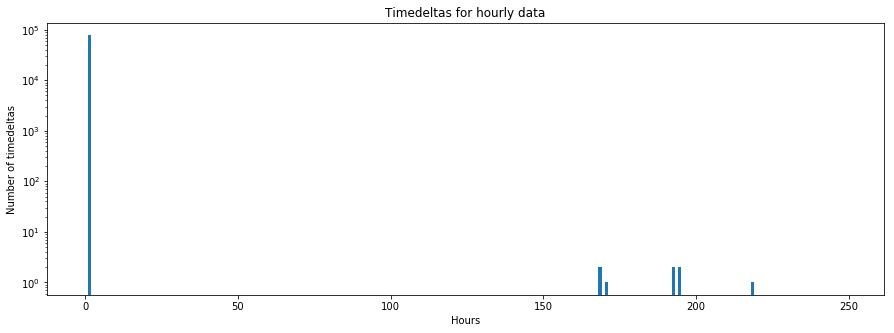

In [25]:
plot_td_hist(deltas, bins=np.arange(0, 250, 1))